## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('../../..')

In [ ]:
from copulae.input import generate_copula_net_input
from copulae.training import setup_training

from copulae.training.cflax.mixtures import LogitPDFNet
from copulae.training.cflax.mixtures import NormalPDFNet

from copulae.training.cflax.bilogit import PositiveBiLogitCopula as PBLC
from copulae.training.cflax.bilogit import SiamesePositiveBiLogitCopula as SPBLC

from copulae.training.cflax.binorm import PositiveBiNormalCopula as PBNC
from copulae.training.cflax.binorm import SiamesePositiveBiNormalCopula as SPBNC

from copulae.training.cflax.mono_aux import PositiveLayer
from copulae.training.cflax.mono_aux import (
    EluPOne, Identity, ResELUPlusOne, ResSoftPlus, SoftPlus
)

from copulae.training.loss import sq_error, sq_error_partial, copula_likelihood
from copulae.training.loss import sq_frechet, sq_valid_partial, sq_valid_density
from copulae.training.loss import cross_entropy, cross_entropy_partial

In [ ]:
import os
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import bootstrap

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import jax.numpy as jnp

In [ ]:
from copulae.training.cflax.mixtures import FrankCopNet
from copulae.training.cflax.mixtures import GaussCopNet
from copulae.training.cflax.mixtures import FGMCopNet
from copulae.training.cflax.mixtures import DoubleIntegral
from copulae.training.cflax.mixtures import MixtureCopula

In [ ]:
def build_mixture(base_class, n, *args, **kwargs):
    rv = []
    for i in range(n):
        rv.append(base_class(*args, **kwargs))
    return MixtureCopula(rv)

In [ ]:
def get_model(model_name):
  layer_widths =  [128, 64, 32, 16]

  if model_name == '2cats_LG':
    return PBLC(LogitPDFNet(layer_widths))

  elif model_name == '2cats_SG':
    return PBNC(NormalPDFNet(layer_widths))

  elif model_name == '2cats_NL':
    return PBLC(PositiveLayer(layer_widths, EluPOne, EluPOne, EluPOne))

  elif model_name == '2cats_NG':
    return PBNC(PositiveLayer(layer_widths, EluPOne, EluPOne, EluPOne))

  elif model_name == '2cats_PGauss':
    return DoubleIntegral(build_mixture(GaussCopNet, 10))

  elif model_name == '2cats_PFrank':
    return DoubleIntegral(build_mixture(FrankCopNet, 10))

  elif model_name == '2cats_PFGM':
    return DoubleIntegral(build_mixture(FGMCopNet, 10))

## Data

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
def test_set(D_val, data_points):
  points = D_val
  points = np.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  density_x = kde_x.evaluate(points[0, 0, :])
  cumulative_x = np.array([kde_x.integrate_box_1d(-np.inf, p) for p in points[0, 0, :]])

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  density_y = kde_y.evaluate(points[0, 1, :])
  cumulative_y = np.array([kde_y.integrate_box_1d(-np.inf, p) for p in points[0, 1, :]])


  I_pdf = density_x.T * density_y.T
  I_pdf = np.expand_dims(I_pdf, axis=0)

  cdf_xy = np.array((cumulative_x, cumulative_y))
  cdf_xy = np.expand_dims(cdf_xy, axis=0)

  return I_pdf, cdf_xy

## Bootstrap

In [ ]:
ROOT = '/content/drive/MyDrive/copulas/models'

MODELS = ['2cats_SL', '2cats_SG', '2cats_NL', '2cats_NG','2cats_PGauss' , '2cats_PFrank', '2cats_PFGM']

In [ ]:
def get_data(dataset_name, TrainingTensors, train_D, test_D):

  losses = [
    (0.01, sq_error),
    (0.5, sq_error_partial),
    (0.1, copula_likelihood),
  ]

  for model_name in MODELS:
    model_path = os.path.join(ROOT, model_name, dataset_name + '.pkl')
    model = get_model(model_name)

    with open(model_path, 'rb') as fp:
      best_params = pickle.load(fp)

    nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
        model, TrainingTensors, losses
    )

    I_pdf, cdf_xy = test_set(test_D, train_D)
    copula_density = nn_c(best_params, cdf_xy)
    points_density = copula_density * I_pdf
    yhat = -np.log(jnp.clip(points_density, 1e-6))
    nll = np.mean(yhat)

    res = bootstrap(yhat, np.mean)
    low = res.confidence_interval.low
    high = res.confidence_interval.high
    emean = (low+high)/2
    rmean = res.bootstrap_distribution.mean()
    dev1 = high - rmean
    dev2 = rmean - low
    dev = dev1 if dev1 > dev2 else dev2


    print(f'{model_name} - NLL: {nll:.4f} EMean: {emean:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: ${rmean:.2f} \pm {dev:.2f}$')

## Gauss $\rho=0.1$

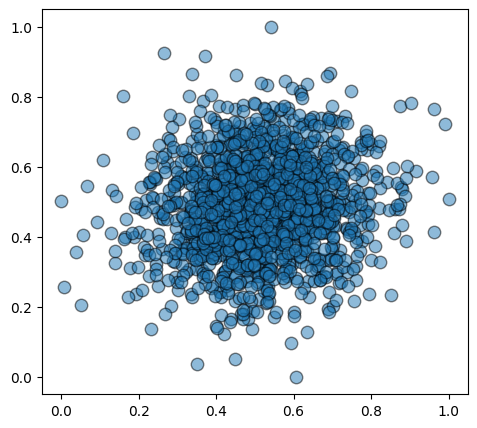

In [ ]:
np.random.seed(30091985)

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('gauss_01', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -0.8862 EMean: -0.8812 RMean: -0.8877 IC: (-1.0360,-0.7264) Notation: $-0.89 \pm 0.16$
2cats_SG - NLL: 0.0139 EMean: 0.0217 RMean: 0.0126 IC: (-0.1500,0.1934) Notation: $0.01 \pm 0.18$
2cats_NL - NLL: -0.1705 EMean: -0.1623 RMean: -0.1706 IC: (-0.3230,-0.0016) Notation: $-0.17 \pm 0.17$
2cats_NG - NLL: -0.1215 EMean: -0.1109 RMean: -0.1216 IC: (-0.2837,0.0619) Notation: $-0.12 \pm 0.18$
2cats_PGauss - NLL: -0.2117 EMean: -0.1844 RMean: -0.2102 IC: (-0.6367,0.2678) Notation: $-0.21 \pm 0.48$
2cats_PFrank - NLL: 0.8222 EMean: 0.8295 RMean: 0.8224 IC: (0.6610,0.9979) Notation: $0.82 \pm 0.18$
2cats_PFGM - NLL: -1.1473 EMean: -1.1299 RMean: -1.1495 IC: (-1.2978,-0.9621) Notation: $-1.15 \pm 0.19$


## Gauss $\rho=0.5$

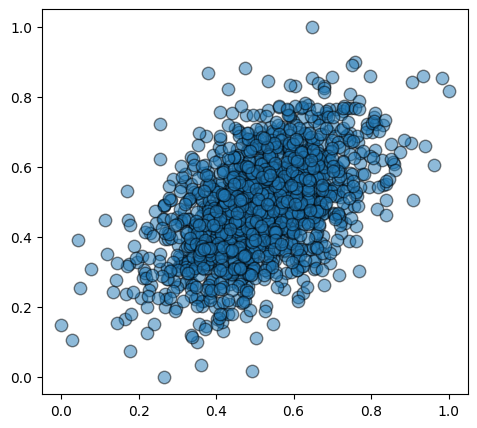

In [ ]:
np.random.seed(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('gauss_05', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -0.8977 EMean: -0.8877 RMean: -0.8994 IC: (-1.0546,-0.7209) Notation: $-0.90 \pm 0.18$
2cats_SG - NLL: -1.1558 EMean: -1.1468 RMean: -1.1568 IC: (-1.3168,-0.9768) Notation: $-1.16 \pm 0.18$
2cats_NL - NLL: -0.2824 EMean: -0.2619 RMean: -0.2826 IC: (-0.4615,-0.0623) Notation: $-0.28 \pm 0.22$
2cats_NG - NLL: -0.3151 EMean: -0.3068 RMean: -0.3149 IC: (-0.4776,-0.1359) Notation: $-0.31 \pm 0.18$
2cats_PGauss - NLL: -0.2552 EMean: -0.2068 RMean: -0.2556 IC: (-0.6670,0.2535) Notation: $-0.26 \pm 0.51$
2cats_PFrank - NLL: 0.5752 EMean: 0.5855 RMean: 0.5751 IC: (0.4273,0.7436) Notation: $0.58 \pm 0.17$
2cats_PFGM - NLL: -1.1763 EMean: -1.1650 RMean: -1.1784 IC: (-1.3271,-1.0028) Notation: $-1.18 \pm 0.18$


## Gauss $\rho=0.9$

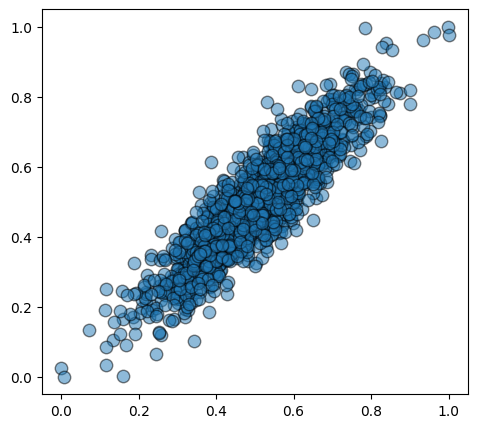

In [ ]:
np.random.seed(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('gauss_09', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -1.3022 EMean: -1.2807 RMean: -1.3051 IC: (-1.5123,-1.0490) Notation: $-1.31 \pm 0.26$
2cats_SG - NLL: -1.5910 EMean: -1.5755 RMean: -1.5923 IC: (-1.7871,-1.3639) Notation: $-1.59 \pm 0.23$
2cats_NL - NLL: -0.6633 EMean: -0.6319 RMean: -0.6622 IC: (-0.9242,-0.3395) Notation: $-0.66 \pm 0.32$
2cats_NG - NLL: -1.3008 EMean: -1.2718 RMean: -1.3016 IC: (-1.5375,-1.0060) Notation: $-1.30 \pm 0.30$
2cats_PGauss - NLL: -1.3470 EMean: -1.3098 RMean: -1.3471 IC: (-1.7502,-0.8694) Notation: $-1.35 \pm 0.48$
2cats_PFrank - NLL: -0.0409 EMean: -0.0248 RMean: -0.0409 IC: (-0.1997,0.1501) Notation: $-0.04 \pm 0.19$
2cats_PFGM - NLL: -1.1302 EMean: -1.1161 RMean: -1.1325 IC: (-1.2953,-0.9370) Notation: $-1.13 \pm 0.20$


## Clayton $\theta = 1$

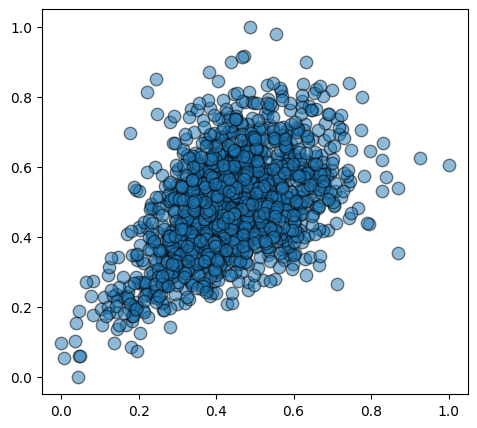

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('clayton_1', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -0.9972 EMean: -0.9931 RMean: -0.9956 IC: (-1.1592,-0.8270) Notation: $-1.00 \pm 0.17$
2cats_SG - NLL: -0.9710 EMean: -0.9585 RMean: -0.9709 IC: (-1.1550,-0.7620) Notation: $-0.97 \pm 0.21$
2cats_NL - NLL: -0.0787 EMean: -0.0730 RMean: -0.0800 IC: (-0.2514,0.1055) Notation: $-0.08 \pm 0.19$
2cats_NG - NLL: -0.1256 EMean: -0.1132 RMean: -0.1259 IC: (-0.3071,0.0807) Notation: $-0.13 \pm 0.21$
2cats_PGauss - NLL: -0.1152 EMean: -0.0821 RMean: -0.1152 IC: (-0.5558,0.3916) Notation: $-0.12 \pm 0.51$
2cats_PFrank - NLL: 0.8605 EMean: 0.8724 RMean: 0.8614 IC: (0.6825,1.0623) Notation: $0.86 \pm 0.20$
2cats_PFGM - NLL: -0.8173 EMean: -0.8043 RMean: -0.8179 IC: (-0.9974,-0.6112) Notation: $-0.82 \pm 0.21$


## Clayton $\theta = 5$

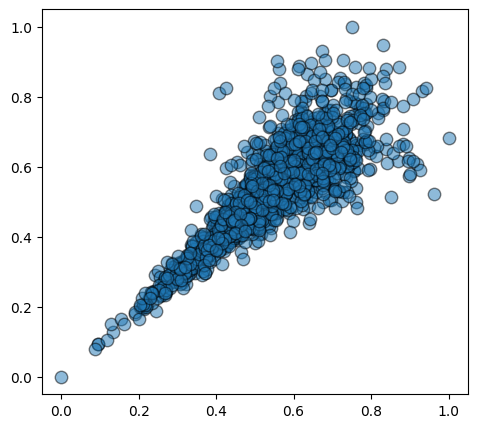

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('clayton_5', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -1.5313 EMean: -1.5245 RMean: -1.5315 IC: (-1.7202,-1.3288) Notation: $-1.53 \pm 0.20$
2cats_SG - NLL: -1.5953 EMean: -1.5607 RMean: -1.5967 IC: (-1.9043,-1.2171) Notation: $-1.60 \pm 0.38$
2cats_NL - NLL: -0.9807 EMean: -0.9526 RMean: -0.9811 IC: (-1.2282,-0.6769) Notation: $-0.98 \pm 0.30$
2cats_NG - NLL: -0.8325 EMean: -0.7935 RMean: -0.8340 IC: (-1.1144,-0.4725) Notation: $-0.83 \pm 0.36$
2cats_PGauss - NLL: 0.5353 EMean: 0.5518 RMean: 0.5381 IC: (0.0221,1.0814) Notation: $0.54 \pm 0.54$
2cats_PFrank - NLL: 0.2196 EMean: 0.2313 RMean: 0.2197 IC: (0.0537,0.4089) Notation: $0.22 \pm 0.19$
2cats_PFGM - NLL: 0.7185 EMean: 0.7395 RMean: 0.7214 IC: (0.2593,1.2197) Notation: $0.72 \pm 0.50$


## Clayton $\theta = 10$

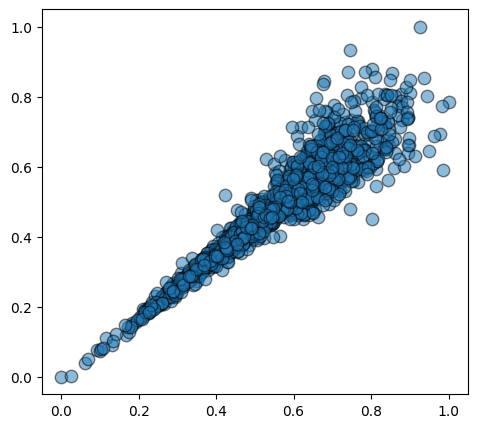

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('clayton_10', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -0.9777 EMean: -0.9662 RMean: -0.9790 IC: (-1.1406,-0.7918) Notation: $-0.98 \pm 0.19$
2cats_SG - NLL: -0.9645 EMean: -0.9568 RMean: -0.9617 IC: (-1.1576,-0.7561) Notation: $-0.96 \pm 0.21$
2cats_NL - NLL: -1.5219 EMean: -1.4937 RMean: -1.5229 IC: (-1.7061,-1.2813) Notation: $-1.52 \pm 0.24$
2cats_NG - NLL: 0.4868 EMean: 0.5111 RMean: 0.4842 IC: (0.0046,1.0175) Notation: $0.48 \pm 0.53$
2cats_PGauss - NLL: 6.6020 EMean: 6.5824 RMean: 6.6022 IC: (5.8294,7.3355) Notation: $6.60 \pm 0.77$
2cats_PFrank - NLL: 0.2224 EMean: 0.2304 RMean: 0.2246 IC: (0.0627,0.3981) Notation: $0.22 \pm 0.17$
2cats_PFGM - NLL: -0.8698 EMean: -0.8576 RMean: -0.8699 IC: (-1.0538,-0.6613) Notation: $-0.87 \pm 0.21$


## Frank $\theta = 1$

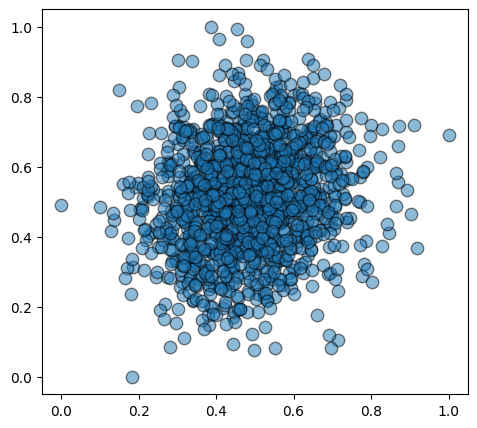

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('frank_1', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -0.6228 EMean: -0.6131 RMean: -0.6229 IC: (-0.7771,-0.4491) Notation: $-0.62 \pm 0.17$
2cats_SG - NLL: -0.9355 EMean: -0.9259 RMean: -0.9359 IC: (-1.1062,-0.7455) Notation: $-0.94 \pm 0.19$
2cats_NL - NLL: -0.3514 EMean: -0.3473 RMean: -0.3504 IC: (-0.4938,-0.2008) Notation: $-0.35 \pm 0.15$
2cats_NG - NLL: -0.3641 EMean: -0.3515 RMean: -0.3633 IC: (-0.5120,-0.1910) Notation: $-0.36 \pm 0.17$
2cats_PGauss - NLL: 0.8026 EMean: 0.8350 RMean: 0.8020 IC: (0.3001,1.3699) Notation: $0.80 \pm 0.57$
2cats_PFrank - NLL: 0.4813 EMean: 0.4886 RMean: 0.4821 IC: (0.3337,0.6435) Notation: $0.48 \pm 0.16$
2cats_PFGM - NLL: -1.4243 EMean: -1.4197 RMean: -1.4242 IC: (-1.5472,-1.2922) Notation: $-1.42 \pm 0.13$


## Frank $\theta = 5$

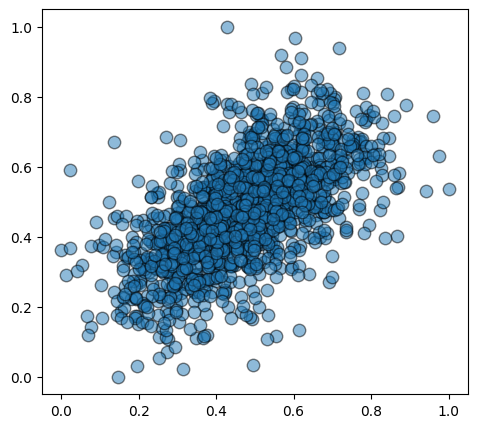

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('frank_5', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -1.2900 EMean: -1.2704 RMean: -1.2895 IC: (-1.4478,-1.0931) Notation: $-1.29 \pm 0.20$
2cats_SG - NLL: -1.6387 EMean: -1.6371 RMean: -1.6395 IC: (-1.8161,-1.4581) Notation: $-1.64 \pm 0.18$
2cats_NL - NLL: -0.4543 EMean: -0.4264 RMean: -0.4523 IC: (-0.6655,-0.1872) Notation: $-0.45 \pm 0.27$
2cats_NG - NLL: -0.3711 EMean: -0.3327 RMean: -0.3688 IC: (-0.6296,-0.0358) Notation: $-0.37 \pm 0.33$
2cats_PGauss - NLL: 0.2308 EMean: 0.2664 RMean: 0.2310 IC: (-0.2382,0.7709) Notation: $0.23 \pm 0.54$
2cats_PFrank - NLL: 0.2561 EMean: 0.2630 RMean: 0.2567 IC: (0.1366,0.3893) Notation: $0.26 \pm 0.13$
2cats_PFGM - NLL: -1.3080 EMean: -1.3019 RMean: -1.3083 IC: (-1.4323,-1.1716) Notation: $-1.31 \pm 0.14$


## Frank $\theta = 10$

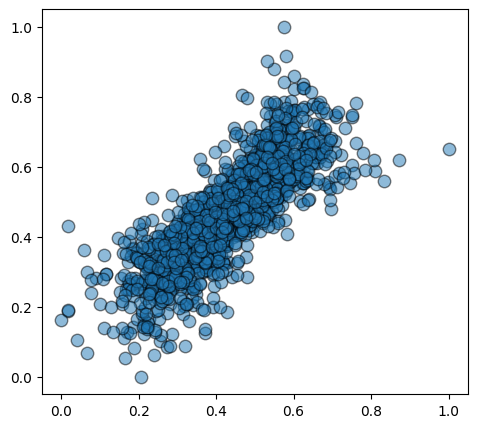

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
get_data('frank_10', TrainingTensors, train_D, test_D)

2cats_LG - NLL: -0.7206 EMean: -0.7026 RMean: -0.7215 IC: (-0.9327,-0.4726) Notation: $-0.72 \pm 0.25$
2cats_SG - NLL: -1.5354 EMean: -1.5301 RMean: -1.5351 IC: (-1.7463,-1.3140) Notation: $-1.54 \pm 0.22$
2cats_NL - NLL: -0.0435 EMean: -0.0127 RMean: -0.0453 IC: (-0.4233,0.3978) Notation: $-0.05 \pm 0.44$
2cats_NG - NLL: 0.0299 EMean: 0.0554 RMean: 0.0329 IC: (-0.3395,0.4503) Notation: $0.03 \pm 0.42$
2cats_PGauss - NLL: -0.3884 EMean: -0.3560 RMean: -0.3830 IC: (-0.8674,0.1553) Notation: $-0.38 \pm 0.54$
2cats_PFrank - NLL: 0.6656 EMean: 0.6898 RMean: 0.6651 IC: (0.4395,0.9401) Notation: $0.67 \pm 0.28$
2cats_PFGM - NLL: 2.8768 EMean: 2.8948 RMean: 2.8746 IC: (2.2676,3.5219) Notation: $2.87 \pm 0.65$
